# TTE R TO PYTHON

## 1. Setup 

A sequence of target trials analysis starts by specifying which estimand will be used:

### Python Equivalent:

In [22]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle
import statsmodels.genmod.generalized_linear_model as sm
sm.SET_USE_BIC_LLF(True)

# Create directories
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Setup trial sequences as dictionaries
trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

Used dictionaries to store trial settings and os to create directories. 
Since there's no direct equivalent to trial_sequence(), so I mimiced the structure at 

<div class="alert alert-block alert-warning">
os.makedirs(..., exist_ok=True) ensures directories are created without raising an error if they already exist. <br>

The trial objects (trial_pp, trial_itt) are dictionaries that will hold all trial-related data and settings.
</div>


___


## 2. Data Preparation

Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used. In the original R code, a parameter called ``` time_on_regime``` is shown on the other steps, however it is only retrieved through ``` switch_n_cov```: 

<div class="alert alert-block alert-info">
switch_n_cov<br>
A RHS formula to specify the logistic models for estimating the numerator terms of the inverse probability of treatment weights. A derived variable named time_on_regime containing the duration of time that the individual has been on the current treatment/non-treatment is available for use in these models.
</div>

Upon checking further, time_on_regime isn't used in any significant functions, so I decided to omit it. 

### Python Equivalent:

In [23]:
# Load data (assuming it's saved as a CSV)
data_censored = pd.read_csv("data_censored.csv")

columns = {
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Assign data and columns to trials
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = columns

trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = columns

# Display the first 6 rows (equivalent to head() in R showing 6 rows)
print(data_censored.head(6))

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         1         0  


Loaded the data from the CSV file and store it in the trial dictionaries. 

Used ```python pd.read_csv()``` instead of ```R data("data_censored")```

In [24]:
def set_data(trial, data, id, period, treatment, outcome, eligible):
    trial["data"] = data.copy()
    trial["columns"] = {
        "id": id,
        "period": period,
        "treatment": treatment,
        "outcome": outcome,
        "eligible": eligible
    }
    trial["n_observations"] = len(data)
    trial["n_patients"] = data[id].nunique()
    
    # Initialize missing keys with default status
    trial["censor_weights"] = {"status": "Not specified"}
    trial["expansion"] = {"status": "Not specified"}
    trial["outcome_model"] = {"status": "Not specified"}
    
    return trial

# Function to display trial object summary
def print_trial_summary(trial):
    print("Trial Sequence Object")
    print(f"Estimand: {trial['estimand']}")
    print("")
    print("Data:")
    print(f" - N: {trial['n_observations']} observations from {trial['n_patients']} patients")
    
    # Select the desired columns
    display_cols = ["id", "period", "treatment", "x1", "x2", "x3", "x4", "age", "age_s", 
                    "outcome", "censored", "eligible"]
    data_display = pd.concat([trial["data"][display_cols].head(2), trial["data"][display_cols].tail(2)])
    
    # Define column types
    col_types = {col: "<int>" if trial["data"][col].dtype == "int64" else "<num>" for col in display_cols}
    
    # Print column headers and types
    print("        " + " ".join(f"{col:>11}" for col in display_cols))
    print("        " + " ".join(f"{col_types[col]:>11}" for col in display_cols))
    
    # Print rows dynamically with their actual indices
    for i, (idx, row) in enumerate(data_display.iterrows()):
        # Right-align the index with a colon, adjusting width to fit larger numbers
        label = f"{idx:>4}:"
        print(label, end=" ")
        formatted_row = [f"{row[col]:>11.6f}" if col_types[col] == "<num>" else f"{int(row[col]):>11}" for col in display_cols]
        print(" ".join(formatted_row))
        # Add ellipsis after the second row (before the last two)
        if i == 1:
            print("    ...")
    
    print("")
    print("IPW for informative censoring:")
    print(f" - {trial['censor_weights']['status']}")
    print("")
    print("Sequence of Trials Data:")
    print(f" - {trial['expansion']['status']}")
    print("")
    print("Outcome model:")
    print(f" - {trial['outcome_model']['status']}")

# Per-protocol
trial_pp = set_data(
    trial_pp,
    data=data_censored,
    id="id",
    period="period",
    treatment="treatment",
    outcome="outcome",
    eligible="eligible"
)

# ITT
trial_itt = set_data(
    trial_itt,
    data=data_censored,
    id="id",
    period="period",
    treatment="treatment",
    outcome="outcome",
    eligible="eligible"
)

# Display the first 6 rows
print("First 6 rows of data_censored:")
print(data_censored.head(6))

# Display trial_itt summary
print("\nTrial ITT Summary:")
print_trial_summary(trial_itt)

First 6 rows of data_censored:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         1         0  

Trial ITT Summary:
Trial Sequence Object
Estimand: ITT

Data:
 - N: 725 observations from 89 patients
                 id      period   treatment          x1          x2          x3          x4         age       age_s     outcome    censor

---

## 3. Weight models and censoring

In [25]:
def set_weight_models(trial, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
    # Store configuration without fitting models yet
    trial[f"{weight_type}_config"] = {
        "censor_event": censor_event,
        "numerator_vars": numerator_vars,
        "denominator_vars": denominator_vars,
        "pool_models": pool_models,
        "save_path": save_path,
        "fitted": False
    }

def show_weight_config(trial, weight_type):
    config = trial.get(f"{weight_type}_config", {})
    if not config:
        return
    print(f"Numerator formula: 1 - censored ~ {' + '.join(config['numerator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['numerator_vars'])}")
    print(f"Denominator formula: 1 - censored ~ {' + '.join(config['denominator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['denominator_vars'])}")
    if weight_type == "censor" and config["pool_models"] == "numerator":
        print("Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    print("Model fitter type: te_stats_glm_logit")
    print("Weight models not fitted.")

# Set and show switch weight models (PP only)
set_weight_models(
    trial_pp,
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=os.path.join(trial_pp["dir"], "switch_models")
)
print("Switch Weight Config for trial_pp:")
show_weight_config(trial_pp, "switch")

# Set and show censor weight models (PP)
set_weight_models(
    trial_pp,
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=os.path.join(trial_pp["dir"], "switch_models")
)
print("\nCensor Weight Config for trial_pp:")
show_weight_config(trial_pp, "censor")

# Set and show censor weight models (ITT)
set_weight_models(
    trial_itt,
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=os.path.join(trial_itt["dir"], "switch_models")
)
print("\nCensor Weight Config for trial_itt:")
show_weight_config(trial_itt, "censor")

Switch Weight Config for trial_pp:
Numerator formula: 1 - censored ~ treatment ~ age
Denominator formula: 1 - censored ~ treatment ~ age + x1 + x3
Model fitter type: te_stats_glm_logit
Weight models not fitted.

Censor Weight Config for trial_pp:
Numerator formula: 1 - censored ~ x2
Denominator formula: 1 - censored ~ x2 + x1
Model fitter type: te_stats_glm_logit
Weight models not fitted.

Censor Weight Config for trial_itt:
Numerator formula: 1 - censored ~ x2
Denominator formula: 1 - censored ~ x2 + x1
Numerator model is pooled across treatment arms. Denominator model is not pooled.
Model fitter type: te_stats_glm_logit
Weight models not fitted.


---

## 4. Calculate Weights

In [26]:
def fit_weight_models(trial, weight_type):
    """
    Fit numerator and denominator models for switch or censor weights based on trial configuration.
    """
    config = trial[f"{weight_type}_config"]
    data = trial["data"].copy()
    models = {}
    
    if weight_type == "switch":
        # Compute previous treatment for switch weights
        data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0).astype(int)
        groups = data.groupby('prev_treatment')
        outcome = 'treatment'
        formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
        formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
        for group_name, group_data in groups:
            model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
            model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
            models[f"n{group_name}"] = model_num
            models[f"d{group_name}"] = model_den
    
    elif weight_type == "censor":
        outcome = config["censor_event"]
        # Define outcome as not censored (1 - censor_event)
        data['not_censored'] = 1 - data[outcome]
        # Compute previous treatment for censor weights
        data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0).astype(int)
        if config["pool_models"] == "numerator":  # ITT case
            # Pooled numerator model across all data
            formula_num = f"not_censored ~ {' + '.join(config['numerator_vars'])}"
            model_num = smf.glm(formula_num, data=data, family=sm.families.Binomial()).fit()
            models["n"] = model_num
            # Separate denominator models by prev_treatment
            formula_den = f"not_censored ~ {' + '.join(config['denominator_vars'])}"
            for group_name, group_data in data.groupby('prev_treatment'):
                model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                models[f"d{group_name}"] = model_den
        else:  # PP case, no pooling
            formula_num = f"not_censored ~ {' + '.join(config['numerator_vars'])}"
            formula_den = f"not_censored ~ {' + '.join(config['denominator_vars'])}"
            for group_name, group_data in data.groupby('prev_treatment'):
                model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
                model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                models[f"n{group_name}"] = model_num
                models[f"d{group_name}"] = model_den
    
    trial[f"{weight_type}_models"] = models
    config["fitted"] = True

def calculate_weights(trial, weight_type):
    """
    Calculate weights using fitted models. Fit models if not already fitted.
    """
    if not trial[f"{weight_type}_config"]["fitted"]:
        fit_weight_models(trial, weight_type)
    
    data = trial["data"].copy()
    models = trial[f"{weight_type}_models"]
    
    if weight_type == "switch":
        if 'prev_treatment' not in data.columns:
            data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0).astype(int)
        weights = pd.Series(index=data.index, dtype=float)
        for group_name in [0, 1]:
            group_data = data[data['prev_treatment'] == group_name]
            idx = group_data.index
            prob_num = models[f"n{group_name}"].predict(group_data)
            prob_den = models[f"d{group_name}"].predict(group_data)
            weights.loc[idx] = np.where(group_data['treatment'] == 1, prob_num / prob_den, (1 - prob_num) / (1 - prob_den))
        data["wt"] = weights
    
    elif weight_type == "censor":
        if 'prev_treatment' not in data.columns:
            data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0).astype(int)
        weights = pd.Series(index=data.index, dtype=float)
        if "n" in models:  # ITT with pooled numerator
            prob_num = models["n"].predict(data)
            for group_name in [0, 1]:
                group_data = data[data['prev_treatment'] == group_name]
                idx = group_data.index
                prob_den = models[f"d{group_name}"].predict(group_data)
                weights.loc[idx] = prob_num.loc[idx] / prob_den
        else:  # PP with separate models
            for group_name in [0, 1]:
                group_data = data[data['prev_treatment'] == group_name]
                idx = group_data.index
                prob_num = models[f"n{group_name}"].predict(group_data)
                prob_den = models[f"d{group_name}"].predict(group_data)
                weights.loc[idx] = prob_num / prob_den
        data["wtC"] = weights
    
    trial["data"] = data
    trial["data"]['censor_weight'] = 1.0

def show_weight_models(trial):
    """
    Display summaries of fitted weight models with specified descriptions and order.
    """
    weight_types = ["censor", "switch"] if trial["estimand"] == "PP" else ["censor"]
    for weight_type in weight_types:
        if f"{weight_type}_models" not in trial:
            continue
        print(f"Weight Models for {'Informative Censoring' if weight_type == 'censor' else 'Treatment Switching'}")
        print("---------------------------------------\n")
        models = trial[f"{weight_type}_models"]
        
        # Set display order based on estimand
        if weight_type == "censor":
            if trial[f"{weight_type}_config"]["pool_models"] == "numerator":
                order = ["n", "d0", "d1"]  # ITT order
            else:
                order = ["n0", "d0", "n1", "d1"]  # PP order
        else:  # switch weights for PP
            order = ["n1", "d1", "n0", "d0"]
        
        for model_key in order:
            if model_key in models:
                model = models[model_key]
                is_numerator = model_key.startswith('n')
                group_name = model_key[1:] if model_key != "n" else ""
                if weight_type == "switch":
                    desc = f"P(treatment = 1 | previous treatment = {group_name}) for {'numerator' if is_numerator else 'denominator'}"
                else:
                    if model_key == "n":
                        desc = "P(censor_event = 0 | X) for numerator"  # ITT pooled numerator
                    else:
                        desc = f"P(censor_event = 0 | X, previous treatment = {group_name}) for {'numerator' if is_numerator else 'denominator'}"
                print(f"[{model_key}]")
                print(f"Model: {desc}")
                print(" ")
                print("term        estimate   std.error statistic p.value")
                params = model.params
                std_err = model.bse
                tvalues = model.tvalues
                pvalues = model.pvalues
                for term in params.index:
                    print(f"{term:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {tvalues[term]:>9.6f} {pvalues[term]:.6e}")
                print(" ")
                print(f"null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
                print(f"{model.null_deviance:.7f} {int(model.nobs-1):>7} {model.llf:>9.4f} {model.aic:>7.4f} {model.bic:>9.4f} {model.deviance:>7.4f} {int(model.df_resid):>7} {int(model.nobs):>7}")
                print(" \n")
# Execute calculations
calculate_weights(trial_pp, "switch")
calculate_weights(trial_pp, "censor")
calculate_weights(trial_itt, "censor")

# Display results
print("Weight Models for trial_itt:")
show_weight_models(trial_itt)
print("\nWeight Models for trial_pp:")
show_weight_models(trial_pp)

Weight Models for trial_itt:
Weight Models for Informative Censoring
---------------------------------------

[n]
Model: P(censor_event = 0 | X) for numerator
 
term        estimate   std.error statistic p.value
Intercept    2.4480907 0.1405747 17.414876 6.362614e-68
x2           -0.4486482 0.1368779 -3.277724 1.046476e-03
 
null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
404.2155891     724 -196.7002 397.4004  406.5727 393.4004     723     725
 

[d0]
Model: P(censor_event = 0 | X, previous treatment = 0) for denominator
 
term        estimate   std.error statistic p.value
Intercept    1.8941961 0.2071136  9.145686 5.925282e-20
x2           -0.5898292 0.1693423 -3.483059 4.957189e-04
x1           0.8552603 0.3452990  2.476869 1.325407e-02
 
null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
283.0722903     425 -132.1655 270.3309  282.4943 264.3309     423     426
 

[d1]
Model: P(censor_event = 0 | X, previous treatment = 1) for den

---
## 5. Specify Outcome Model

In [27]:
def set_outcome_model(trial, adjustment_terms=None):
    numerator_vars = []
    if "censor_config" in trial:
        numerator_vars.extend(trial["censor_config"]["numerator_vars"])
    if trial["estimand"] == "PP" and "switch_config" in trial:
        numerator_vars.extend(trial["switch_config"]["numerator_vars"])
    numerator_vars = list(set(numerator_vars))
    if adjustment_terms:
        numerator_vars.extend([var for var in adjustment_terms if var not in numerator_vars])
    outcome_model_vars = ["treatment", "followup_time"] + numerator_vars
    trial["outcome_model_vars"] = outcome_model_vars
    outcome = trial["columns"]["outcome"]
    formula = f"{outcome} ~ {' + '.join(outcome_model_vars)}"
    trial["outcome_model_formula"] = formula

set_outcome_model(trial_pp)
set_outcome_model(trial_itt, adjustment_terms=["x2"])


---
## 6. Expand Trials

In [28]:
def expand_trials(trial):
    data = trial["data"]
    trial_type = trial["estimand"]
    expanded_data = []
    
    # Get unique periods where patients are eligible
    eligible_periods = data[data["eligible"] == 1]["period"].unique()
    
    for trial_period in eligible_periods:
        # Patients eligible at this trial_period
        eligible_patients = data[(data["period"] == trial_period) & 
                                (data["eligible"] == 1)]["id"].unique()
        
        for patient_id in eligible_patients:
            # Get patient data from trial_period onward
            patient_data = data[(data["id"] == patient_id) & 
                               (data["period"] >= trial_period)].sort_values("period")
            if len(patient_data) == 0:
                continue
                
            patient_data = patient_data.set_index("period")
            assigned_treatment = patient_data.loc[trial_period, "treatment"]
            
            # Define stopping condition
            if trial_type == "ITT":
                stopping_condition = (patient_data["outcome"] == 1) | (patient_data["censored"] == 1)
            else:  # PP
                stopping_condition = (patient_data["outcome"] == 1) | \
                                    (patient_data["censored"] == 1) | \
                                    (patient_data["treatment"] != assigned_treatment)
            
            # Get periods up to the first stopping point
            stopping_periods = patient_data.index[stopping_condition]
            if len(stopping_periods) > 0:
                max_period = stopping_periods.min()
                periods = patient_data.index[(patient_data.index >= trial_period) & 
                                            (patient_data.index <= max_period)]
            else:
                periods = patient_data.index[patient_data.index >= trial_period]
            
            # Compute cumulative weights over all periods
            if trial_type == "ITT":
                patient_data["cum_weight"] = np.cumprod(patient_data["wtC"])
            else:  # PP
                patient_data["cum_weight"] = np.cumprod(patient_data["wt"] * patient_data["wtC"])
            
            # Create expanded rows for each period
            for period in periods:
                followup_time = period - trial_period
                weights_up_to_t = patient_data.loc[trial_period:period]
                wt_cum = weights_up_to_t["cum_weight"].iloc[-1] if len(weights_up_to_t) > 1 else 1.0
                
                row = {
                    "id": patient_id,
                    "trial_period": trial_period,
                    "followup_time": followup_time,
                    "outcome": patient_data.loc[period, "outcome"],
                    "treatment": patient_data.loc[period, "treatment"],
                    "assigned_treatment": assigned_treatment,
                    "x2": patient_data.loc[trial_period, "x2"],
                    "age": patient_data.loc[trial_period, "age"],
                    "weight": wt_cum
                }
                expanded_data.append(row)
    
    expanded_df = pd.DataFrame(expanded_data)
    trial["expanded_data"] = expanded_df
    return expanded_df

# Run the function
expand_trials(trial_pp)
expand_trials(trial_itt)

,id,trial_period,followup_time,outcome,treatment,assigned_treatment,x2,age,weight
0,1,0,0,0,1,1,1.146148,36,1.000000
1,1,0,1,0,1,1,1.146148,36,0.927411
2,1,0,2,0,1,1,1.146148,36,0.918067
3,1,0,3,0,1,1,1.146148,36,0.895420
4,1,0,4,0,1,1,1.146148,36,0.837756
...,...,...,...,...,...,...,...,...,...
1553,54,16,2,0,0,0,0.817996,68,1.160119
1554,54,16,3,0,0,0,0.817996,68,1.136104
1555,54,17,0,0,1,1,1.846423,69,1.000000
1556,54,17,1,0,0,1,1.846423,69,1.182371


---
## 7. Load or Sample from Expanded Data

In [29]:
def load_expanded_data(trial, seed=1234, p_control=0.5):
    """
    Load and prepare expanded data for the trial, including sampling and sample weights.
    
    Parameters:
    - trial: Dictionary containing trial data.
    - seed: Random seed for reproducibility.
    - p_control: Probability of sampling control observations (default 0.5).
    """
    np.random.seed(seed)
    data = trial["expanded_data"].copy()
    
    # Define masks for cases (outcome == 1) and controls (outcome == 0)
    case_mask = (data['outcome'] == 1)
    control_mask = (data['outcome'] == 0)
    
    # Randomly sample controls with probability p_control
    sample_mask = np.random.random(len(data)) < p_control
    
    # Keep all cases and sampled controls
    mask = case_mask | (control_mask & sample_mask)
    loaded_data = data[mask].copy()
    
    # Initialize sample_weight column
    loaded_data['sample_weight'] = 1.0  # Default weight for cases
    # Adjust weights for sampled controls
    loaded_data.loc[control_mask & sample_mask, 'sample_weight'] = 1.0 / p_control
    
    trial["loaded_data"] = loaded_data
    return trial

load_expanded_data(trial_itt)


{'estimand': 'ITT',
 'dir': 'c:\\Users\\User\\Documents\\GitHub\\Clustering-Assignment-1\\trial_itt',
 'data':      id  period  treatment  x1        x2  x3        x4  age     age_s  \
 0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
 1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
 2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
 3     1       3          1   0  0.007872   0  0.734203   39  0.333333   
 4     1       4          1   1  0.216054   0  0.734203   40  0.416667   
 ..   ..     ...        ...  ..       ...  ..       ...  ...       ...   
 720  99       3          0   0 -0.747906   1  0.575268   68  2.750000   
 721  99       4          0   0 -0.790056   1  0.575268   69  2.833333   
 722  99       5          1   1  0.387429   1  0.575268   70  2.916667   
 723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
 724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   
 


---
## 8. Fit Marginal Structural Model

In [30]:
def fit_msm(trial, formula):
    data = trial["loaded_data"]
    msm_model = smf.logit(formula, data).fit()
    trial["outcome_model_fitted"] = msm_model
    trial["outcome_model_formula"] = formula
    print(msm_model.summary())
    return msm_model

# Assuming Step 8 has been run, re-run it to ensure the model is stored
formula = "outcome ~ assigned_treatment + x2 + trial_period + I(trial_period**2)"
msm_itt = fit_msm(trial_itt, formula)


         Current function value: 0.077355
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  781
Model:                          Logit   Df Residuals:                      776
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                  0.1391
Time:                        13:56:44   Log-Likelihood:                -60.414
converged:                      False   LL-Null:                       -70.175
Covariance Type:            nonrobust   LLR p-value:                 0.0006205
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.3576      0.602     -7.236      0.000      -5.538      -3.177
assigned_treatment       1.4906    

c:\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


---
## 9. Interference


c:\Python312\Lib\site-packages\scipy\stats\_multivariate.py:762: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


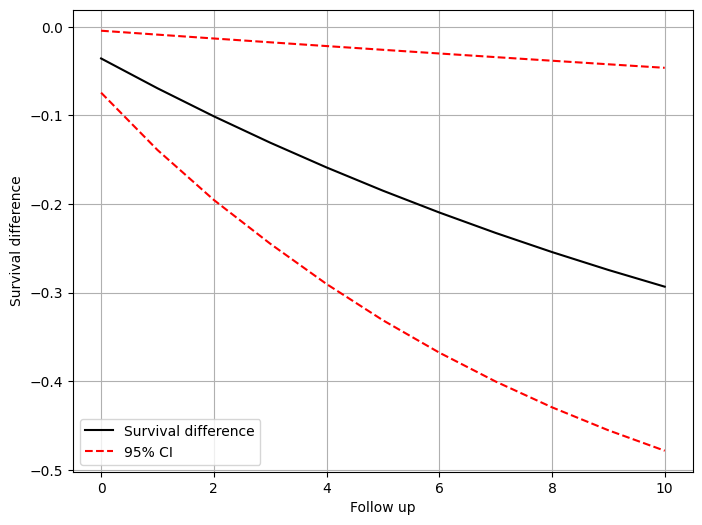

In [ ]:
def predict(trial, newdata=None, predict_times=None, type='survival', conf_int=True, samples=100):

    if predict_times is None:
        predict_times = list(range(11))

    # Extract fitted model and formula
    if "outcome_model_fitted" not in trial:
        raise KeyError("Fitted model not found in trial['outcome_model_fitted']. Run fit_msm first.")
    model = trial["outcome_model_fitted"]
    if "outcome_model_formula" not in trial:
        raise KeyError("Formula not found in trial['outcome_model_formula']. Ensure fit_msm sets it.")
    formula = trial["outcome_model_formula"].split("~")[1].strip()

    # Prepare newdata: filter trial_period == 1
    if newdata is None:
        if "loaded_data" not in trial:
            raise KeyError("No 'loaded_data' in trial. Ensure data is loaded.")
        newdata = trial["loaded_data"][trial["loaded_data"]["trial_period"] == 1].copy()
    else:
        newdata = newdata[newdata["trial_period"] == 1].copy()

    # Extract base variables from the formula
    predictor_terms = [var.strip() for var in formula.split(" + ")]
    base_vars = [var for var in predictor_terms if not var.startswith("I(") and var != "assigned_treatment"]
    for term in predictor_terms:
        if term == "I(followup_time ** 2)":
            base_vars.append("followup_time")
        elif term == "I(trial_period ** 2)":
            base_vars.append("trial_period")
    base_vars = list(set(base_vars))  # Remove duplicates
    if "id" in trial["loaded_data"].columns:
        base_vars.append("id")  # Include id if present
    newdata = newdata[base_vars].copy()

    # Replicate data for each prediction time
    n_baseline = len(newdata)
    newdata = pd.concat([newdata] * len(predict_times), ignore_index=True)
    newdata["followup_time"] = np.tile(predict_times, n_baseline)
    newdata["trial_period"] = 1  # Fixed at trial_period = 1

    # Add polynomial terms if in formula
    if "I(followup_time ** 2)" in predictor_terms:
        newdata["followup_time_sq"] = newdata["followup_time"] ** 2
    if "I(trial_period ** 2)" in predictor_terms:
        newdata["trial_period_sq"] = newdata["trial_period"] ** 2

    # Prepare coefficient samples
    coefs = model.params.values
    cov_matrix = model.cov_params()
    if conf_int:
        coefs_samples = multivariate_normal.rvs(mean=coefs, cov=cov_matrix, size=samples)
    else:
        coefs_samples = [coefs]

    # Predict for treatment and control
    pred_results = {}
    for treatment in [0, 1]:
        temp_data = newdata.copy()
        temp_data["assigned_treatment"] = treatment
        exog = dmatrix(formula, temp_data, return_type="dataframe")
        
        preds = []
        for coef_sample in coefs_samples:
            linear_pred = np.dot(exog, coef_sample)
            probs = 1 / (1 + np.exp(-linear_pred))  # Logistic transformation
            probs_matrix = probs.reshape(n_baseline, len(predict_times), order='F')
            
            if type == 'survival':
                survival = np.cumprod(1 - probs_matrix, axis=1)
                result = survival.mean(axis=0)
            else:  # cum_inc
                result = 1 - np.cumprod(1 - probs_matrix, axis=1).mean(axis=0)
            preds.append(result)
        
        pred_results[f'assigned_treatment_{treatment}'] = np.array(preds).T

    # Compute difference
    diff_preds = pred_results['assigned_treatment_1'] - pred_results['assigned_treatment_0']

    # Prepare results
    results = {
        'assigned_treatment_0': {
            'followup_time': predict_times,
            'survival': pred_results['assigned_treatment_0'][:, 0]
        },
        'assigned_treatment_1': {
            'followup_time': predict_times,
            'survival': pred_results['assigned_treatment_1'][:, 0]
        },
        'difference': {
            'followup_time': predict_times,
            'survival_diff': diff_preds[:, 0]
        }
    }
    if conf_int:
        results['difference']['2.5%'] = np.percentile(diff_preds, 2.5, axis=1)
        results['difference']['97.5%'] = np.percentile(diff_preds, 97.5, axis=1)

    return results

def plot_survival_difference(preds):
    """
    Plot survival difference with confidence intervals matching R style.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(preds['difference']['followup_time'], 
             preds['difference']['survival_diff'], 
             'k-', 
             label="Survival difference")
    plt.plot(preds['difference']['followup_time'], 
             preds['difference']['2.5%'], 
             'r--', 
             label="95% CI")
    plt.plot(preds['difference']['followup_time'], 
             preds['difference']['97.5%'], 
             'r--')
    plt.xlabel("Follow up")
    plt.ylabel("Survival difference")
    plt.grid(True)
    plt.legend()
    plt.show()


# Step 9: Inference
predict_times = list(range(11))
preds = predict(trial_itt, newdata=trial_itt["loaded_data"], predict_times=predict_times, type="survival")
plot_survival_difference(preds)